## Project Overview: Predicting Medical Insurance Costs

Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Loading data

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv')

In [6]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

EDA

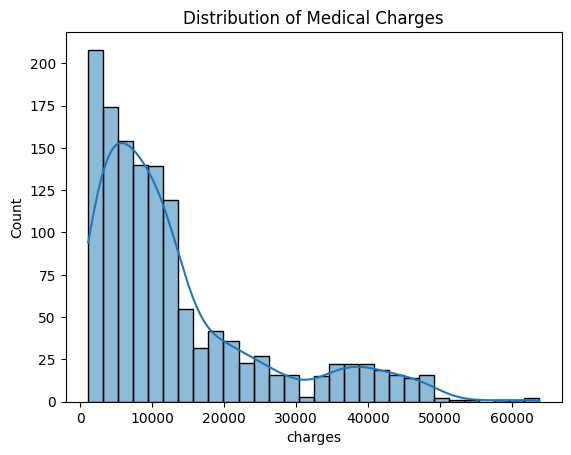

In [9]:
sns.histplot(df['charges'], kde=True)
plt.title("Distribution of Medical Charges")
plt.show()

Interpretation : 

• Most people have lower charges

• This skew suggests that Linear Regression might not be ideal without transformation, because linear models work better with normally distributed targets.



What this means : 

•We might consider log-transforming the target (charges) later to normalize it and improve model performance.

•High-cost outliers (very expensive insurance cases) could influence the model disproportionately.

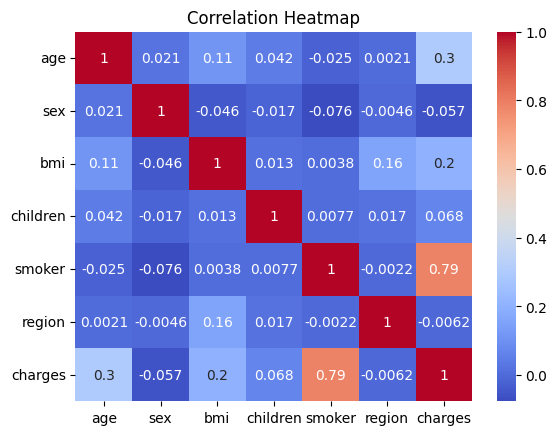

In [10]:
# Correlation Heatmap
# Convert categoricals to numerical temporarily
df_encoded = df.copy()
df_encoded['sex'] = df_encoded['sex'].map({'male': 0, 'female': 1})
df_encoded['smoker'] = df_encoded['smoker'].map({'no': 0, 'yes': 1})
df_encoded['region'] = df_encoded['region'].astype('category').cat.codes

sns.heatmap(df_encoded.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


This tells us there is a strong correlation between smokers and chargers, meaning people who smoke have increased medical costs

Also BMI and Age affect the charges

Sex, number of children and region have very low correlation with the charges, hence they can be ignored

• Hence, Smokers, Age and BMI are the strong candidates to be included as important predictors, we can drop other features

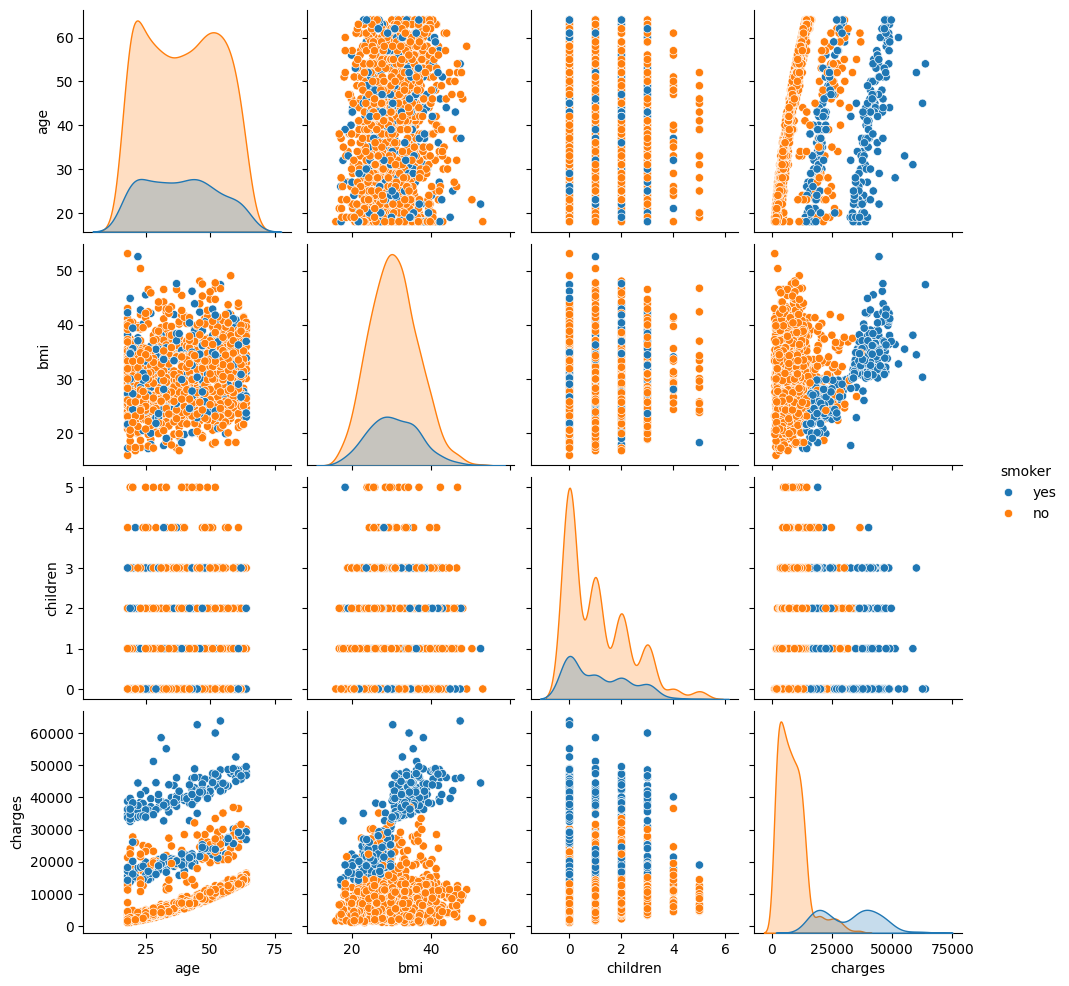

In [11]:
sns.pairplot(df, hue="smoker")
plt.show()

If we look at the charges row, blue are smokers, orange are non-smokers
• Charges vs Age : Medical costs tend to rise with age, but again smokers show much higher charges at all ages. There's a clear vertical separation between smokers and non-smokers.

• Charges vs BMI :  BMI + Smoker = expensive.

This means we can do some feature engineering later on with bmi x smoker or age x smoker to get better results


Data processing:  converting categorical variables to dummies

In [13]:
df_processed = pd.get_dummies(df, drop_first=True) #drop_first solves redundant columns
df_processed.head()


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


Splitting data for training and testing

In [14]:
X = df_processed.drop("charges", axis=1)
y = df_processed["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Making the model

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Coefficients

In [16]:
coeff_df = pd.DataFrame(lr.coef_, X.columns, columns=["Coefficient"])
print(coeff_df)


                   Coefficient
age                 256.975706
bmi                 337.092552
children            425.278784
sex_male            -18.591692
smoker_yes        23651.128856
region_northwest   -370.677326
region_southeast   -657.864297
region_southwest   -809.799354


In [17]:
y_pred = lr.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


R² Score: 0.7835929767120724
MAE: 4181.194473753649
MSE: 33596915.85136145
RMSE: 5796.284659276273


78 percent accuracy

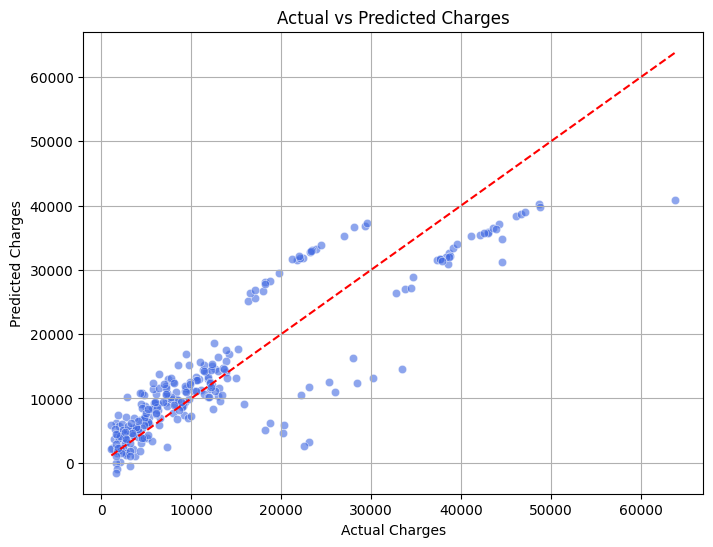

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')  # Perfect prediction line
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted Charges")
plt.grid(True)
plt.show()

Interpretation : Model isnt quite accurate for higher charges

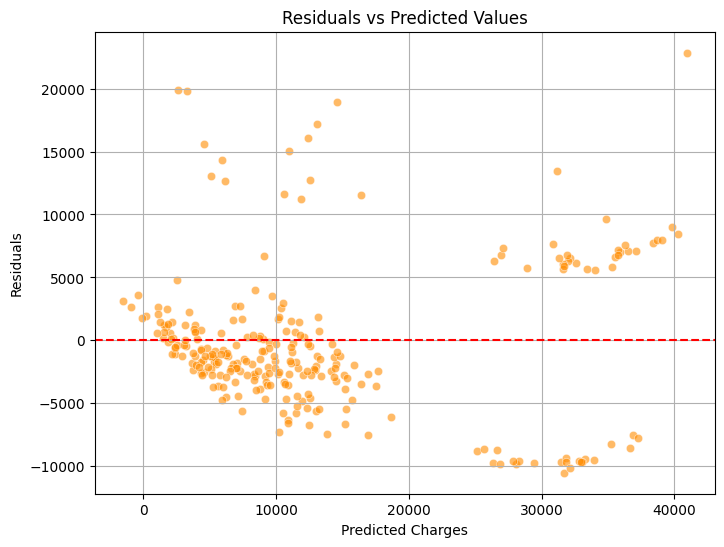

In [19]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, color='darkorange')
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Predicted Charges")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.grid(True)
plt.show()


This is showing some issues:

1) This plot should show a random scatter of points forming an approximately constant width band around the identity line, but it is not showing that. Hence this model is underfitting, it can’t capture non-linear relationships in the data. The model assumes a straight-line relationship, but the real data curve is more complex.

2) The spread of residuals is not constant.

## Fixing the model

#### What are interaction terms

Effect =  When two features combine to influence the target in a non-additive way.
Not all terms are independently influencing the model

The new term: bmi * smoker_yes lets the model adjust the effect of BMI based on smoking status. Similarly, age * smoker_yes

In [20]:
df_processed.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


In [21]:
df_processed['bmi_smoker'] = df_processed['bmi'] * df_processed['smoker_yes']
df_processed['age_smoker'] = df_processed['age'] * df_processed['smoker_yes']

In [22]:
df_processed.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,bmi_smoker,age_smoker
0,19,27.900,0,16884.92400,False,True,False,False,True,27.9,19
1,18,33.770,1,1725.55230,True,False,False,True,False,0.0,0
2,28,33.000,3,4449.46200,True,False,False,True,False,0.0,0
3,33,22.705,0,21984.47061,True,False,True,False,False,0.0,0
4,32,28.880,0,3866.85520,True,False,True,False,False,0.0,0


In [23]:
X = df_processed.drop(['charges'], axis=1)
y = df_processed['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))

R² Score: 0.8652316979531679


86 percent accurate, we are getting better

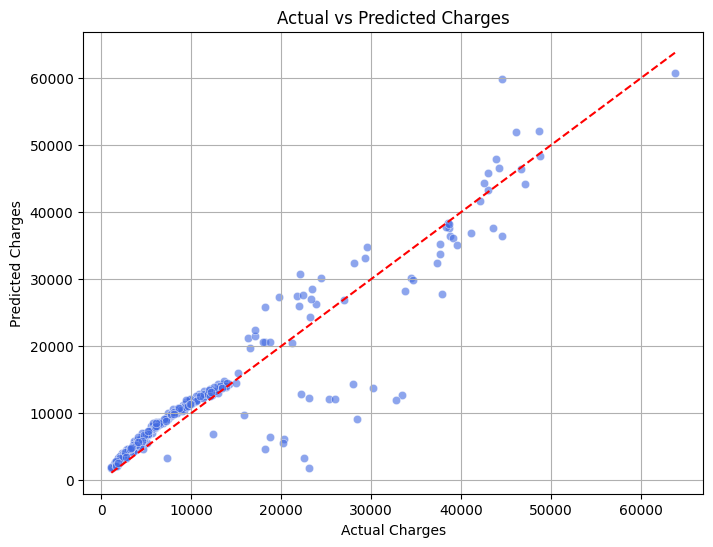

In [24]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')  # Perfect prediction line
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted Charges")
plt.grid(True)
plt.show()

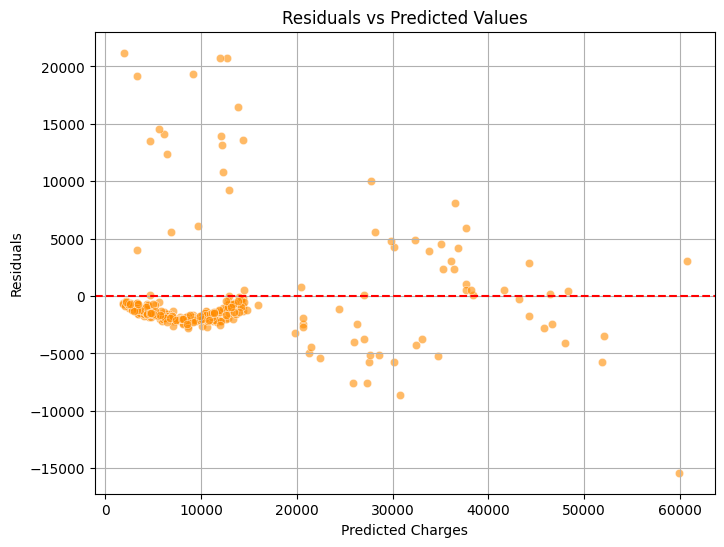

In [25]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, color='darkorange')
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Predicted Charges")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.grid(True)
plt.show()


This is better, but the residuals show that there is a U forming near low charges, we have to fix that

Residual plot shows that the model is still missing some non-linear interactions or transformations.

## Log-Transforming [charges]

Intuition : right now, our target [charges] is highly right-skewed, Linear regression works better when target values are roughly symmetric

the log transformations compresses large values, makes the target more normally distributed, improves prediction accuracy especially for high-cost cases



In [26]:
df_processed['log_charges'] = np.log(df['charges'])

In [33]:
X = df_processed.drop(['charges', 'log_charges'], axis=1)
y = df_processed['log_charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))

R² Score: 0.853688392134992


In [29]:
# Predict in log scale
y_pred_log = lr.predict(X_test)

# Convert back to actual charges
y_pred = np.exp(y_pred_log)

# For comparison
y_test_actual = np.exp(y_test)

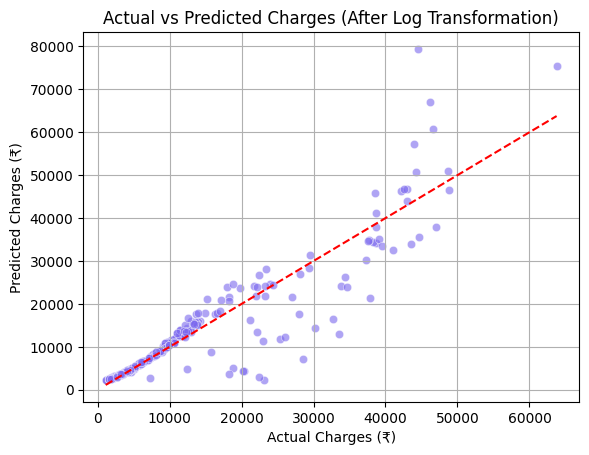

In [30]:
sns.scatterplot(x=y_test_actual, y=y_pred, alpha=0.6, color='mediumslateblue')
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], '--r')
plt.xlabel("Actual Charges (₹)")
plt.ylabel("Predicted Charges (₹)")
plt.title("Actual vs Predicted Charges (After Log Transformation)")
plt.grid(True)
plt.show()

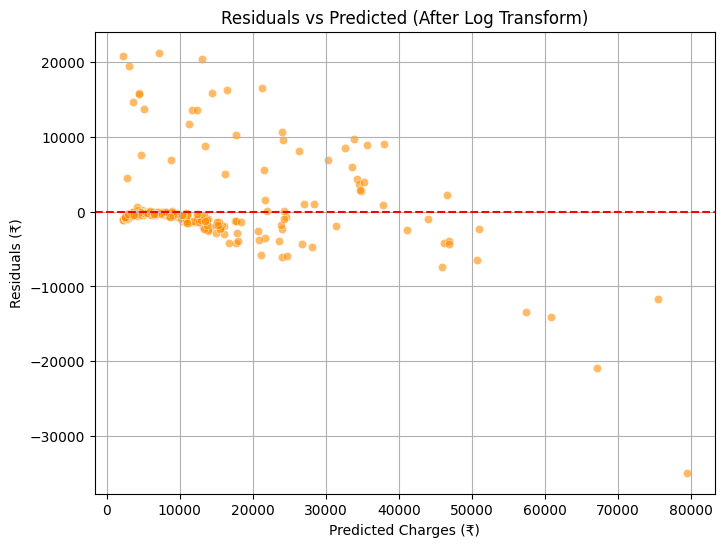

In [31]:
residuals = y_test_actual - y_pred

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, color='darkorange')
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Predicted Charges (₹)")
plt.ylabel("Residuals (₹)")
plt.title("Residuals vs Predicted (After Log Transform)")
plt.grid(True)
plt.show()

We have almost maxed out the capabilites of just Linear Regression. To get a better result, especially for higher charge values, we need to use other models like ridge/lasso regression, random forest regressor, XG boost